# Hybrid Gradient Boosting Trees Classification Example 

A data set that identifies whether or not a pentient has diabetes is used to demonstrate the use of hybrid graident boosting classifier in SAP HANA.



# Pima Indians Diabetes Dataset

Original data comes from National Institute of Diabetes and Digestive and Kidney Diseases. The collected dataset is aiming at, based on certain diagnostic measurements, diagnostically predicting whether or not a patient has diabetes. In particular, patients contained in the dataset are females of Pima Indian heritage, all above the age of 20. Dataset is form Kaggle, for tutorials use only.

The dataset contains the following diagnositic <b>attributes</b>:<br>
$\rhd$ "PREGNANCIES" - Number of times pregnant,<br>
$\rhd$ "GLUCOSE" - Plasma glucose concentration a 2 hours in an oral glucose tolerance test,<br>
$\rhd$ "BLOODPRESSURE" -  Diastolic blood pressure (mm Hg),<br>
$\rhd$ "SKINTHICKNESS" -  Triceps skin fold thickness (mm),<br>
$\rhd$ "INSULIN" - 2-Hour serum insulin (mu U/ml),<br>
$\rhd$ "BMI" - Body mass index $(\text{weight in kg})/(\text{height in m})^2$,<br>
$\rhd$ "PEDIGREE" - Diabetes pedigree function,<br>
$\rhd$ "AGE" -  Age (years),<br>
$\rhd$ "CLASS" - Class variable (0 or 1) 268 of 768 are 1(diabetes), the others are 0(non-diabetes).



In [1]:
import hana_ml
from hana_ml import dataframe
from hana_ml.algorithms.pal import metrics
from hana_ml.algorithms.pal.trees import HybridGradientBoostingClassifier

# Load Data

The data is loaded into 3 tables - full set, training-validation set, and test set as follows:

<li> PIMA_INDIANS_DIABETES_TBL</li>
<li> PIMA_INDIANS_DIABETES_TRAIN_VALID_TBL</li>
<li> PIMA_INDIANS_DIABETES_TEST_TBL</li>

To do that, a connection is created and passed to the loader.

There is a config file, <b>config/e2edata.ini</b> that controls the connection parameters and whether or not to reload the data from scratch. In case the data is already loaded, there would be no need to load the data. A sample section is below. If the config parameter, reload_data is true then the tables for test, training and validation are (re-)created and data inserted into them.

#########################<br>
[hana]<br>
url=host.sjc.sap.corp<br>
user=username<br>
passwd=userpassword<br>
port=3xx15<br>
#########################<br>

In [2]:
from data_load_utils import DataSets, Settings
import plotting_utils
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, training_valid_tbl, test_tbl, _ = DataSets.load_diabetes_data(connection_context)

Table PIMA_INDIANS_DIABETES_TBL exists and data exists


# Create Data Frames

Create the data frames for the full, test, training, and validation sets.

Let us also do some data exploration.

# Define Datasets - training, validation and test sets

Data frames are used keep references to data so computation on large data sets in HANA can happen in HANA. Trying to bring the entire data set into the client will likely result in out of memory exceptions.

The original/full dataset is split into training, test and validation sets. In the example below, they reside in different tables.

In [3]:
diabetes_full = connection_context.table(full_tbl)
diabetes_train_valid = connection_context.table(training_valid_tbl)
diabetes_test = connection_context.table(test_tbl)

# Simple Exploration

Let us look at the number of rows in each dataset:

In [4]:
print('Number of rows in full set: {}'.format(diabetes_full.count()))
print('Number of rows in training-validation set: {}'.format(diabetes_train_valid.count()))
print('Number of rows in test set: {}'.format(diabetes_test.count()))

Number of rows in full set: 768
Number of rows in training-validation set: 614
Number of rows in test set: 76


Let us look at columns of the dataset:

In [5]:
print(diabetes_full.columns)

['ID', 'PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'PEDIGREE', 'AGE', 'CLASS']


Let us also look some (in this example, the top 6) rows of the dataset:

In [6]:
diabetes_full.head(6).collect()

,ID,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,PEDIGREE,AGE,CLASS
0,1,6,102,90,39,0,35.7,0.674,28,0
1,2,11,127,106,0,0,39.0,0.190,51,0
2,3,13,145,82,19,110,22.2,0.245,57,0
3,4,4,123,62,0,0,32.0,0.226,35,1
4,5,7,100,0,0,0,30.0,0.484,32,1
5,6,4,154,62,31,284,32.8,0.237,23,0


We can also check the data type of all columns:

In [7]:
diabetes_full.dtypes()

[('ID', 'INT', 10, 10, 10, 0),
 ('PREGNANCIES', 'INT', 10, 10, 10, 0),
 ('GLUCOSE', 'INT', 10, 10, 10, 0),
 ('BLOODPRESSURE', 'INT', 10, 10, 10, 0),
 ('SKINTHICKNESS', 'INT', 10, 10, 10, 0),
 ('INSULIN', 'INT', 10, 10, 10, 0),
 ('BMI', 'DOUBLE', 15, 15, 15, 0),
 ('PEDIGREE', 'DOUBLE', 15, 15, 15, 0),
 ('AGE', 'INT', 10, 10, 10, 0),
 ('CLASS', 'INT', 10, 10, 10, 0)]

We have a 'CLASS' column in the dataset, let us check how many classes are contained in this dataset:

In [8]:
diabetes_full.distinct('CLASS').collect()

,CLASS
0,0
1,1


Two classes are available, assuring that this is a binary classification problem.

In [9]:
print(diabetes_test.columns)

['ID', 'PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'PEDIGREE', 'AGE', 'CLASS']


#  Model Creation & Model Selection
The lines below show the ease with which classification can be done.

Set up the label column, use default feature set and create the model:

In [20]:
cv_range = []
cv_range.append(('learning_rate',[0.1, 1.0, 3]))
cv_range.append(('n_estimators', [4, 10, 3]))
cv_range.append(('split_threshold', [0.1, 1.0, 3]))
hgc = HybridGradientBoostingClassifier(n_estimators=4, split_threshold=0,
                                       learning_rate=0.5, fold_num=5, max_depth=6,
                                       resampling_method='cv', cross_validation_range=cv_range,
                                       evaluation_metric='error_rate')
hgc.fit(diabetes_train_valid, key= 'ID', label='CLASS', categorical_variable=['CLASS'])

In [21]:
from hana_ml.algorithms.pal.model_selection import GridSearchCV
from hana_ml.algorithms.pal.model_selection import RandomSearchCV
hgc2 = HybridGradientBoostingClassifier(max_depth=6)

gscv = GridSearchCV(estimator=hgc2, 
                    param_grid={'learning_rate': [0.1, 0.4, 0.7, 1],
                                'n_estimators': [4, 6, 8, 10],
                                'split_threshold': [0.1, 0.4, 0.7, 1]},
                    train_control={"fold_num": 5, "resampling_method": 'cv'}, scoring='error_rate')
gscv.fit(data=diabetes_train_valid, key= 'ID', label='CLASS', categorical_variable=['CLASS'])

# Evaluation

Let us compare cross-validation accuracy and test accuracy:

In [22]:
cm = hgc.confusion_matrix_.collect()
cm

,ACTUAL_CLASS,PREDICTED_CLASS,COUNT
0,0,0,379
1,0,1,17
2,1,0,38
3,1,1,180


In [23]:
gscv.estimator.confusion_matrix_.collect()

,ACTUAL_CLASS,PREDICTED_CLASS,COUNT
0,0,0,388
1,0,1,8
2,1,0,13
3,1,1,205


In [24]:
train_accuracy = float(cm['COUNT'][cm['ACTUAL_CLASS']==cm['PREDICTED_CLASS']].sum())/cm['COUNT'].sum()
train_accuracy

0.9104234527687296

In [25]:
features = diabetes_full.columns
features.remove('CLASS')
features.remove('ID')
print(features)

['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'PEDIGREE', 'AGE']


In [26]:
pred_res = hgc.predict(diabetes_test, key='ID', features=features)
pred_res.head(10).collect()
pred_res.dtypes()

[('ID', 'INT', 10, 10, 10, 0),
 ('SCORE', 'NVARCHAR', 100, 100, 100, 0),
 ('CONFIDENCE', 'DOUBLE', 15, 15, 15, 0)]

In [27]:
ts = diabetes_test.rename_columns({'ID': 'TID'}) .cast('CLASS', 'NVARCHAR(256)')
jsql = '{}."{}"={}."{}"'.format(pred_res.quoted_name, 'ID', ts.quoted_name, 'TID')
results_df = pred_res.join(ts, jsql, how='inner')
cm_df, classification_report_df = metrics.confusion_matrix(results_df, key='ID', label_true='CLASS', label_pred='SCORE') 

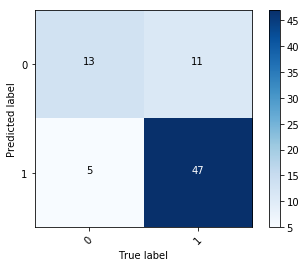

In [28]:
import matplotlib.pyplot as plt
from hana_ml.visualizers.metrics import MetricsVisualizer
f, ax1 = plt.subplots(1,1)
mv1 = MetricsVisualizer(ax1)
ax1 = mv1.plot_confusion_matrix(cm_df, normalize=False)

In [29]:
print("Recall, Precision and F_measures.")
classification_report_df.collect()

Recall, Precision and F_measures.


,CLASS,RECALL,PRECISION,F_MEASURE,SUPPORT
0,0,0.903846,0.810345,0.854545,52
1,1,0.541667,0.722222,0.619048,24


In [31]:
from hana_ml.model_storage import ModelStorage
from hana_ml.model_storage_services import ModelSavingServices


# Creates an object model_storage

# model storage must use the same connection than the model
model_storage = ModelStorage(connection_context=connection_context)

# Saves the model
gscv.estimator.name = 'Model A'  # The model name is mandatory
gscv.estimator.version = 1
model_storage.save_model(model=gscv.estimator)
#need to increase version

# Lists models
model_storage.list_models()

,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTAMP,MODEL_STORAGE_VER
0,Model A,1,PAL,hana_ml.algorithms.pal.unified_classification....,"{""model_attributes"": {""kwargs"": {""param_search...",2020-08-13 13:33:50,1
1,Model A,2,PAL,hana_ml.algorithms.pal.trees.HybridGradientBoo...,"{""model_attributes"": {""cross_validation_range""...",2020-08-13 13:52:28,1
